# Vehicle Detection and Tracking

## The pipeline is as follows:
1. Feature extraction using: spatial binning, color histogram, and HOGs
2. Normalize the features and randomize the data into training and testing sets
3. The train a linear SVM classifier
4. Implement a sliding window technique to search for vehicles in the image
5. Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers   
   and follow detected vehicles.
6. Estimate a bounding box for vehicles detected.
7. Keep track of cars to limit the search area in subsequent frames to speed-up the algorithm

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import pickle
from scipy.ndimage.measurements import label
#from sklearn.svm import LinearSVC
#import sklearn.svm as svm
from sklearn import svm, tree

## Extract Features (HOG, color, and spatial binning)

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)): #bins range is not necessary and can screw up is using png files
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [3]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, image_type = 'jpg'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        if image_type == ('jpg' or 'jpeg'): image = plt.imread(file) #plt reads image in RGB format
        if image_type == ('png'): image = np.array(plt.imread(file)*255, dtype=np.uint8) #plt reads image in RGB format
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, 
                                        bins_range=hist_range)
            #features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features_list = []
                for channel in range(feature_image.shape[2]):
                    hog_features_list.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))                
                hog_features = np.ravel(hog_features_list)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            #features.append(hog_features)
        comb_features = np.concatenate((spatial_features,hist_features,hog_features))
        features.append(comb_features)
    # Return list of feature vectors
    return features

#The extract_features function has been modified to take in single images
def single_image_features_extract(image, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins, 
                                    bins_range=hist_range)
        #features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features_list = []
            for channel in range(feature_image.shape[2]):
                hog_features_list.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features_list) 
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        #features.append(hog_features)
    comb_features = np.concatenate((spatial_features,hist_features,hog_features))
    features.append(comb_features)
    # Return list of feature vectors
    return features

In [4]:
# # Read in cars and notcars from the subset dataset
# images = glob.glob('../subset_data/*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

# train_img_shape = plt.imread(cars[0]).shape
# #print(len(cars))
# #print(len(notcars))

# Read in cars and noncars from the full dataset
img1 = glob.glob('training_data/vehicles/GTI_Far/*.png')
img2 = glob.glob('training_data/vehicles/GTI_Left/*.png')
img3 = glob.glob('training_data/vehicles/GTI_MiddleClose/*.png')
img4 = glob.glob('training_data/vehicles/GTI_Right/image*.png')
img5 = glob.glob('training_data/vehicles/KITTI_extracted/*.png')
cars = img1+img2+img3+img4+img5

img1 = glob.glob('training_data/non-vehicles/Extras/*.png')
img2 = glob.glob('training_data/non-vehicles/GTI/*.png')
notcars = img1+img2

train_img_shape = plt.imread(cars[0]).shape
print(train_img_shape)
print(len(cars))
print(len(notcars))

(64, 64, 3)
8792
9666


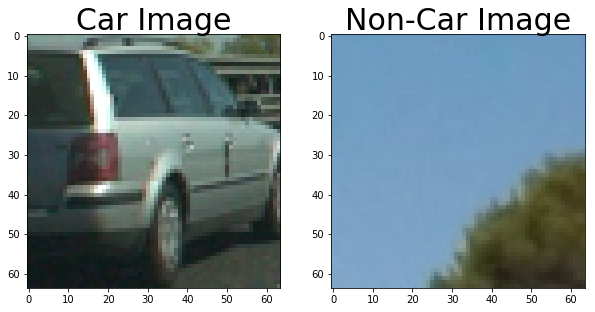

In [5]:
#Test images showing cars and non cars
rand_car = np.random.randint(0,len(cars))
rand_notcar = np.random.randint(0,len(notcars))
test_car = np.array(plt.imread(cars[rand_car])*255, dtype=np.uint8)
test_noncar = np.array(plt.imread(notcars[rand_notcar])*255, dtype=np.uint8)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(test_car)
ax1.set_title('Car Image',fontsize=30)
ax2.imshow(test_noncar)
ax2.set_title('Non-Car Image', fontsize=30)

In [6]:
#IMPORTANT PARAMETERS (USED FOR TRAINING AND TESTING)
colorspace = 'YCrCb' #'YUV' #YCrCb' #LUV' #'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8 #16 #8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial = 32 #64 #32
histbin = 16
hist_range=(0, 256)
spatial_feat = True
hist_feat = True
hog_feat = True

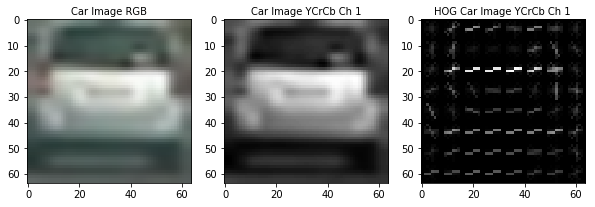

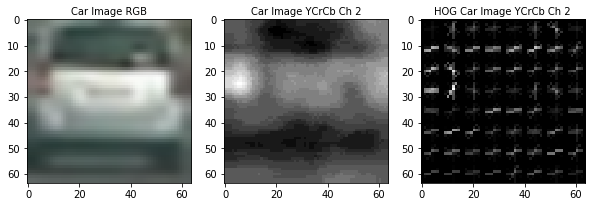

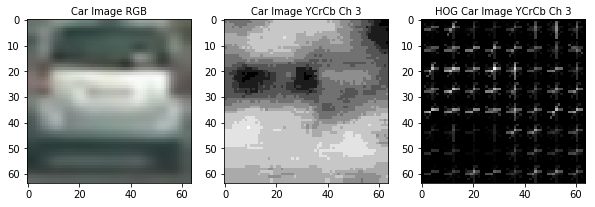

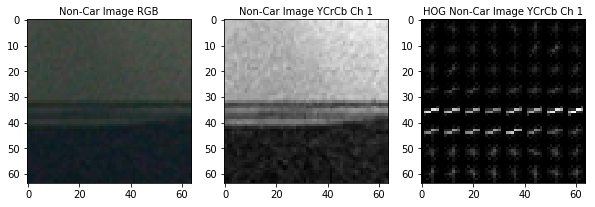

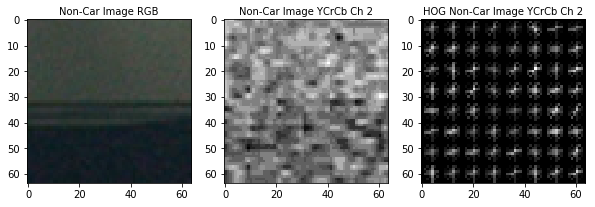

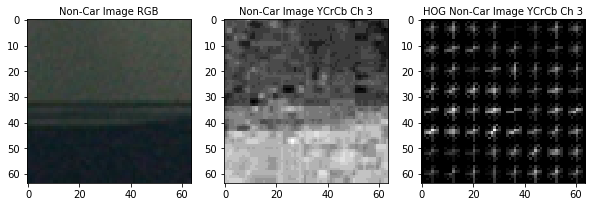

In [7]:
#test car
test_cs = cv2.cvtColor(test_car, cv2.COLOR_RGB2YCrCb)
test_ch = test_cs[:,:,0]
test_hog, hog_image = get_hog_features(test_ch, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
ax1.imshow(test_car)
ax1.set_title('Car Image RGB',fontsize=10)
ax2.imshow(test_ch,cmap='gray')
ax2.set_title('Car Image YCrCb Ch 1', fontsize=10)
ax3.imshow(hog_image,cmap='gray')
ax3.set_title('HOG Car Image YCrCb Ch 1', fontsize=10)

test_cs = cv2.cvtColor(test_car, cv2.COLOR_RGB2YCrCb)
test_ch = test_cs[:,:,1]
test_hog, hog_image = get_hog_features(test_ch, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
ax1.imshow(test_car)
ax1.set_title('Car Image RGB',fontsize=10)
ax2.imshow(test_ch,cmap='gray')
ax2.set_title('Car Image YCrCb Ch 2', fontsize=10)
ax3.imshow(hog_image,cmap='gray')
ax3.set_title('HOG Car Image YCrCb Ch 2', fontsize=10)

test_cs = cv2.cvtColor(test_car, cv2.COLOR_RGB2YCrCb)
test_ch = test_cs[:,:,2]
test_hog, hog_image = get_hog_features(test_ch, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
ax1.imshow(test_car)
ax1.set_title('Car Image RGB',fontsize=10)
ax2.imshow(test_ch,cmap='gray')
ax2.set_title('Car Image YCrCb Ch 3', fontsize=10)
ax3.imshow(hog_image,cmap='gray')
ax3.set_title('HOG Car Image YCrCb Ch 3', fontsize=10)

#test non-car
test_cs = cv2.cvtColor(test_noncar, cv2.COLOR_RGB2YCrCb)
test_ch = test_cs[:,:,0]
test_hog, hog_image = get_hog_features(test_ch, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
ax1.imshow(test_noncar)
ax1.set_title('Non-Car Image RGB',fontsize=10)
ax2.imshow(test_ch,cmap='gray')
ax2.set_title('Non-Car Image YCrCb Ch 1', fontsize=10)
ax3.imshow(hog_image,cmap='gray')
ax3.set_title('HOG Non-Car Image YCrCb Ch 1', fontsize=10)

test_cs = cv2.cvtColor(test_noncar, cv2.COLOR_RGB2YCrCb)
test_ch = test_cs[:,:,1]
test_hog, hog_image = get_hog_features(test_ch, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
ax1.imshow(test_noncar)
ax1.set_title('Non-Car Image RGB',fontsize=10)
ax2.imshow(test_ch,cmap='gray')
ax2.set_title('Non-Car Image YCrCb Ch 2', fontsize=10)
ax3.imshow(hog_image,cmap='gray')
ax3.set_title('HOG Non-Car Image YCrCb Ch 2', fontsize=10)

test_cs = cv2.cvtColor(test_noncar, cv2.COLOR_RGB2YCrCb)
test_ch = test_cs[:,:,2]
test_hog, hog_image = get_hog_features(test_ch, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
ax1.imshow(test_noncar)
ax1.set_title('Non-Car Image RGB',fontsize=10)
ax2.imshow(test_ch,cmap='gray')
ax2.set_title('Non-Car Image YCrCb Ch 3', fontsize=10)
ax3.imshow(hog_image,cmap='gray')
ax3.set_title('HOG Non-Car Image YCrCb Ch 3', fontsize=10)

In [8]:
car_features = extract_features(cars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, image_type='png')

notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, image_type='png')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) #vertically stacks all the elements(np.arrays) in car_features as well as in notcar_features and vertically stacks them                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [9]:
print(len(car_features))
print(len(notcar_features))
print(X.shape)
#print(np.vstack(car_features).shape)
# Define the labels vector
print(y.shape)
print(X_train.shape)
print(X_test.shape)

#pickle.dump(X, open("X_pickle.p", "wb")) #gives memorydump error as its too large

8792
9666
(18458, 8412)
(18458,)
(14766, 8412)
(3692, 8412)


In [10]:
#delete these variables for memory constarints
del X, car_features, notcar_features

## Train an SVM Classifier

In [11]:
# Use a linear SVC (really linear SVM) to train the classifier
svc = svm.LinearSVC()
#svc = tree.DecisionTreeClassifier()
#svc = svm.SVC() #really slow
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')
print(prediction)

43.7301299571991 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.993499458288
0.0021827220916748047 Seconds to predict with SVC
[ 1.]


## Sliding Window

In [12]:
# Here is the draw_boxes function
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = int(xs*nx_pix_per_step + x_start_stop[0])
            endx = int(startx + xy_window[0])
            starty = int(ys*ny_pix_per_step + y_start_stop[0])
            endy = int(starty + xy_window[1])
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

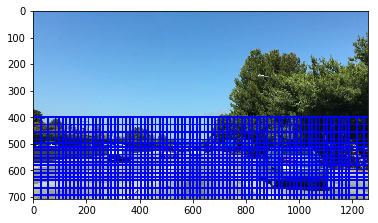

In [19]:
xy_window_list = ((96,96),()) #(48,48))
xy_overlap_list=((0.7, 0.7),())#(0.6, 0.6)) #this helps the most

#Test the sliding window function
image = plt.imread('../bbox-example-image.jpg')
img_size = image.shape
window_list = []
for ii in range(len(xy_window_list)-1):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, img_size[0]], 
                        xy_window=xy_window_list[ii], xy_overlap=xy_overlap_list[ii])
    window_list += windows
                       
window_img = draw_boxes(image, window_list, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

In [20]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

## Main Pipeline

In [21]:
#classes for tracking cars over multiple frames to limit search area
class Vehicle(object):
#class to keep track of vehicle detections. This will help limit the search window for faster processing
    #Instantiator
    def __init__(self,bbox):
        self.max_track = 10 #maximum number of frames for coordinates to track
        self.detected = False #is the vehicle detected in the current frame?
        self.n_detections = 0 #number of times this vehicle has been detected
        self.n_nondetections = 0 #number of consecutive times this vehicle has not been detected
        
        self.pos = bbox #current detection's position e.g. [[100,200],[300,400]] i.e. [top_left, bot_right]
        self.centroid = self.calc_centroid(self.pos) #current detection's centroid of the bounding box e.g. np array([150,250]) i.e. [x,y]
        
        self.recent_pos = [self.pos] #keep track of the last (max of self.max_track) detections (self.max_track x 2 x 2 (x,y) numbers in the list
                             #e.g. [[[100,200],[300,400]], [[100,200],[300,400]], [[100,200],[300,400]], etc]
            
        self.best_pos = [] #mean of the recent detections e.g. [[100,200],[300,400]] i.e. [top_left, bot_right]
        self.best_centroid = [] #mean of the recent detections #e.g. [150,250] i.e. [x,y]

    def calc_centroid(self,pos):
        pos = np.array(pos)
        centroid = np.mean(pos,axis=0)
        return centroid
    
    def calc_best_pos(self): #could also use calc_centroid but this is more readable
        pos_list = np.array(self.recent_pos)
        self.best_pos = np.mean(pos_list,axis=0,dtype=np.int32)
        self.best_centroid = np.mean(self.best_pos,axis=0)
    
class frame_tracking(object):
#Class to keep track of vehicle detections frames
    #Instantiator
    def __init__(self):
        #variables to track frames to track
        self.frame_track = []
        self.num_frame_track = 1000 #for image and 10 for video
        self.heat_thresh = 0 #for image and 5 for video
        
        #variables to track vehicle detections for fast searching
        self.fast_search_counter = 0
        self.full_search_counter = 0
        self.can_do_fast_search = False
        self.cars_detected  = [] #list of vehicles that are detected
        self.similarity_factor = 0.1 #10%
        self.min_good_detections = 10
        
        #variables for debug only
        self.num_use_full_search = 0
        self.num_use_fast_search = 0
    
    def is_same_car(self,car1,car2):
        cnt1 = np.array(car1.best_centroid)
        cnt2 = np.array(car2.centroid)
        is_same = np.max(np.abs(cnt1/cnt2 - 1)) < self.similarity_factor
        return is_same
    
    def update_cars_detected(self,curr_frame_cars):
        cars_to_remove = [] #list of cars to remove from self.cars_detected
        cars_to_add = np.ones(len(curr_frame_cars)) #list of cars to add from curr_frame_cars (1=yes and 0=no)
        for ii in range(len(self.cars_detected)):
            self.cars_detected[ii].detected = False
            for jj in range(len(curr_frame_cars)):
                new_car = curr_frame_cars[jj]
                if self.is_same_car(self.cars_detected[ii],new_car): #compare to the best pos of the detected car
                    self.cars_detected[ii].pos = new_car.pos
                    self.cars_detected[ii].recent_pos.append(new_car.pos)
                    self.cars_detected[ii].detected = True
                    self.cars_detected[ii].n_detections += 1
                    #reduce non detection by 1 everytime the car is detected
                    self.cars_detected[ii].n_nondetections = np.max((0,self.cars_detected[ii].n_nondetections - 1)) 
                    if len(self.cars_detected[ii].recent_pos) > self.cars_detected[ii].max_track:
                        self.cars_detected[ii].recent_pos.pop(0) #remove the first entry (like a queue)
                    cars_to_add[jj] = 0

            if self.cars_detected[ii].detected == False:
                self.cars_detected[ii].n_nondetections += 1
                #reduce detection by 1 everytime the car is not detected
                self.cars_detected[ii].n_detections = np.max((0,self.cars_detected[ii].n_detections - 1)) 
                if self.cars_detected[ii].n_nondetections > 3: #change this to 5
                    cars_to_remove.append(ii)                

        #remove the undetected cars
        for ii in cars_to_remove:
            remove_car = self.cars_detected.pop(ii)
        
        #add the new cars
        for jj in range(len(cars_to_add)):
            if cars_to_add[jj] == 1:
                self.cars_detected.append(curr_frame_cars[jj])

        #calculate the best position for all the cars in the list
        self.can_do_fast_search = True #Note: if cars_detected list is empty then it will stay True but thats ok
        for car in self.cars_detected:
            car.calc_best_pos()
            if car.n_detections < self.min_good_detections:
                self.can_do_fast_search = False


In [22]:
global frames_tracked
frames_tracked = frame_tracking() #instantiate a new object of vehicle class and reset object variables

In [23]:
# Here is code to classify each window using the model trained above
def pred_preprocess_image(image):
    #image needs to be jpg type or png that is 0 to 255 in np.uint8 datatype
    image = cv2.resize(image,(train_img_shape[1],train_img_shape[0])) #make image same size as the training set images
    img_features = single_image_features_extract(image, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    # Create an array stack of feature vectors
    X = np.array(img_features).astype(np.float64)                        
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return scaled_X

def classify_boxes(img, bboxes, classify_model, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    bbox_cars = []
    for bbox in bboxes:
        # classify the rectangle given bbox coordinates
        strt_x = bbox[0][0]
        strt_y = bbox[0][1]
        stp_x = bbox[1][0]
        stp_y = bbox[1][1]
        classify_img = img[strt_y:stp_y,strt_x:stp_x]
        prep_img = pred_preprocess_image(classify_img)
        
        #PREPROCESS ENTIRE IMAGE TO SPEED THINGS UP!!!
        
        pred = sigmoid(classify_model.decision_function(prep_img.reshape(1,-1))) #gives the probability
        #pred = classify_model.predict(prep_img.reshape(1,-1))
        if pred > 0.65:
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick) #negative thickness fills the rectangle
            #text = 'Prob: ' + str(round(pred[0],2))
            #cv2.putText(imcopy,text, bbox[0], cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),2,cv2.LINE_AA)
            bbox_cars.append((bbox[0], bbox[1], pred))
             
    return imcopy, bbox_cars


def bbox_size(bbox):
    size = np.sqrt((bbox[0][0]-bbox[1][0])**2 + (bbox[0][1]-bbox[1][1])**2)
    return size

# #Generate heatmap
# def add_heat(heatmap, bbox_list):
#     # Iterate through list of bboxes
#     for box in bbox_list:
#         # Add += 1 for all pixels inside each bbox
#         heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
#     # Return updated heatmap
#     return heatmap

#Generate heatmap
def gen_heat_map(image, bbox_list):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    #expand sligtly each box to cover for gaps
    expansion_factor = 0.01 #1.0% expansion each side so 2% total   
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        ystrt = int(box[0][1]*(1-expansion_factor))
        ystp = int(box[1][1]*(1+expansion_factor))
        xstrt = int(box[0][0]*(1-expansion_factor))
        xstp = int(box[1][0]*(1+expansion_factor))
        
        heatmap[ystrt:ystp,xstrt:xstp] += 1
    # Return updated heatmap
    return heatmap


def merge_regions(heat):
    #no expansion to cover gaps
    #merge regions before thresholding
    labels = label(heat)
    heat_new = np.zeros_like(heat)
    for car_number in range(1,labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        heat_new[nonzero] = np.max(heat[nonzero])
    return heat_new


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= (threshold)] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, heat):
    # Iterate through all detected cars
    labels = label(heat) #find labels using thresholded heatmap
    #print(labels[1], 'cars found')
    #plt.imshow(labels[0], cmap='gray')
    #plt.show()
    
    img_size = img.shape
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        low_x = np.min(nonzerox)
        low_y = np.min(nonzeroy)
        high_x = np.max(nonzerox)
        high_y = np.max(nonzeroy)
        bbox = [[low_x, low_y], [high_x, high_y]]
        if bbox_size(bbox) > 40: # Only draw boxes that greater than a certain size
#             if high_y < img_size[0]*0.9:
#                 #print(car_number)
#                 box_ht = high_y-low_y
#                 if box_ht > img_size[0]*0.1:
#                     bbox[0][1] =  np.int(bbox[0][1] + 0.05*box_ht)
#                     bbox[1][1] = np.int( bbox[1][1] - 0.05*box_ht)
#                     print(car_number)
            cv2.rectangle(img, (bbox[0][0],bbox[0][1]), (bbox[1][0],bbox[1][1]), (0,0,255), 6)
        
    # Return the image
    return img
   
def draw_labeled_bboxes_2(img, heat):
    # Iterate through all detected cars
    labels = label(heat) #find labels using thresholded heatmap
    #print(labels[1], 'cars found')
    #plt.imshow(labels[0], cmap='gray')
    #plt.show()
    
    curr_frame_cars = []
    img_size = img.shape
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        low_x = np.min(nonzerox)
        low_y = np.min(nonzeroy)
        high_x = np.max(nonzerox)
        high_y = np.max(nonzeroy)
        bbox = [[low_x, low_y], [high_x, high_y]]
        if bbox_size(bbox) > 40: # Only draw boxes that greater than a certain size
            cv2.rectangle(img, (bbox[0][0],bbox[0][1]), (bbox[1][0],bbox[1][1]), (0,0,255), 6)
            curr_frame_cars.append(Vehicle(bbox)) #add car to the local list
        
    frames_tracked.update_cars_detected(curr_frame_cars) #update detcted cars list in frames_tracked
    #for car in frames_tracked.cars_detected: #draw the best pos of the detected car in the last few frames
    #    cv2.rectangle(img,(car.best_pos[0][0],car.best_pos[0][1]),(car.best_pos[1][0],car.best_pos[1][1]),
    #                 (0,0,255), 6)
    
    # Return the image
    return img

# # Read in a pickle file with bboxes saved
# bbdict = pickle.load(open( "bbox_cars.p", "rb" ))
# # Extract "bboxes" field from bbdict
# # Each item in the "all_bboxes" list will contain a 
# # list of boxes for one of the images shown above
# all_bboxes = bbdict #bbdict["bboxes"]

In [24]:
bbox_size(((100,100),(200,200)))
#frames_tracked.prev_frame_bbox_list

141.42135623730951

In [25]:
tst_img = plt.imread('../bbox-example-image.jpg')
tst_img_feat = pred_preprocess_image(tst_img)
print(svc.decision_function(X_test[0:10].reshape(10,-1)))
print(svc.predict(X_test[0:10].reshape(10,-1)))
print(sigmoid(svc.decision_function(X_test[0:10].reshape(10,-1))))

[ 2.64088578  2.71886195  3.91810115  4.17636764 -3.35121568  2.66619317
 -2.25767462  2.71418351 -2.26585559  1.97023937]
[ 1.  1.  1.  1.  0.  1.  0.  1.  0.  1.]
[ 0.93344701  0.93813051  0.98050866  0.98487801  0.03385538  0.93500206
  0.09468952  0.93785841  0.09399054  0.87763682]


In [26]:
#delete these variables for memory constarints
del X_train, X_test, y, y_train, y_test, scaled_X

In [27]:
def detection_pipeline(image=image):
    ###image = image[0:200,0:200,:] #only for debug
    
    img_size = image.shape
    xy_window_list = ((96,96),(48,48))
    xy_overlap_list=((0.7, 0.7), (0.6, 0.6)) #this helps the most
    windows_list = []
    #search for cars in the bottom half of the image
    
    if (frames_tracked.full_search_counter < 5) or (frames_tracked.can_do_fast_search == False): #full search
        #print('full detection: ', frames_tracked.full_search_counter)
        for ii in range(len(xy_window_list)):
            windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, img_size[0]],
                                   xy_window=xy_window_list[ii], xy_overlap=xy_overlap_list[ii])
            windows_list = windows_list + windows #it just extends the list
        
        #print(len(windows_list))
        frames_tracked.full_search_counter += 1
        frames_tracked.fast_search_counter = 0
        
        #for debug only
        frames_tracked.num_use_full_search += 1
        
    else: #fast search
        #print('fast detection: ', frames_tracked.full_search_counter)
        for car in frames_tracked.cars_detected:
            search_area_bbox = car.best_pos
            for ii in range(len(xy_window_list)):
                xstrt = np.max((0,search_area_bbox[0][0]-200))
                xstp = np.min((img_size[1],search_area_bbox[1][0]+200))
                ystrt = np.max((400,search_area_bbox[0][1]-200))
                ystp = np.min((img_size[0],search_area_bbox[1][1]+200))
                windows = slide_window(image, x_start_stop=[xstrt, xstp], y_start_stop=[ystrt, ystp],
                                       xy_window=xy_window_list[ii], xy_overlap=xy_overlap_list[ii])
                windows_list = windows_list + windows #it just extends the list
                
        frames_tracked.fast_search_counter += 1
        frames_tracked.full_search_counter = 5 #redundant but added for readability
        if frames_tracked.fast_search_counter > 4:
            frames_tracked.full_search_counter = 4 #only do 1 time afterwards and 5 times the first time
        #for debug only
        frames_tracked.num_use_fast_search += 1
    
    #print(len(windows_list))
    window_img, bbox_cars = classify_boxes(image, windows_list, svc, color=(0, 0, 255), thick=6)                    
    #print('raw detections')
    #plt.imshow(window_img)
    #plt.show()

    
    #print(bbox_cars)
    heat = gen_heat_map(image,bbox_cars) #add heat map and and 2% expansion to cover gaps
    #print('Heat Map')
    #plt.imshow(heat,cmap='hot')
    #plt.show()
    #print(np.sum(heat))
    #print(heat.shape)
    
    heat = merge_regions(heat) #merge common regions 
    #print('Merge Heat Maps')
    #plt.imshow(heat,cmap='hot')
    #plt.show()

    frames_tracked.frame_track.append(heat)
    
    if len(frames_tracked.frame_track) < (frames_tracked.num_frame_track):
        heat_sum = np.copy(heat)
    
    else:
        heat_sum = np.zeros_like(heat)
        for frame_heat in frames_tracked.frame_track:
            heat_sum += frame_heat #add heat maps over multiple frames
        remove_frame = frames_tracked.frame_track.pop(0) #remove the first one like in a queue
    
    
    heat = apply_threshold(heat_sum,frames_tracked.heat_thresh)
    #print('Thresholded heat map')
    #plt.imshow(heat,cmap='hot')
    #plt.show()


    img_bbox = draw_labeled_bboxes_2(np.copy(image),heat)
    #plt.imshow(img_bbox)
    #plt.show()

    if len(frames_tracked.cars_detected)>4: print(len(frames_tracked.cars_detected))
    
    return img_bbox

In [ ]:
#Test the sliding window function that makes predicitons
t0 = time.time()
frames_tracked = frame_tracking() #instantiate a new object of vehicle class and reset object variables
frames_tracked.full_search_counter = -1000 #only do full search
image = plt.imread('../bbox-example-image.jpg')
final_image = detection_pipeline(image)
plt.imshow(final_image)
plt.show()
t1 = time.time()
print('Time Taken:',t1-t0)

In [ ]:
frames_tracked.cars_detected[0].recent_pos

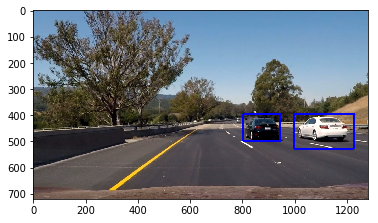

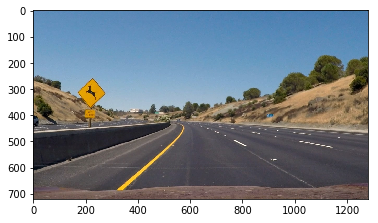

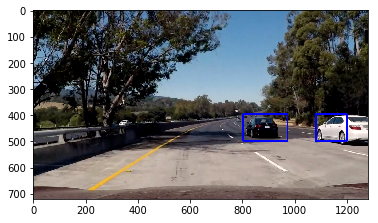

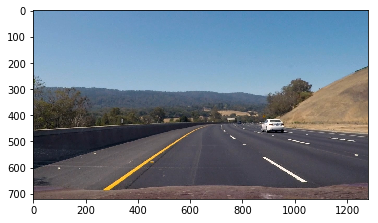

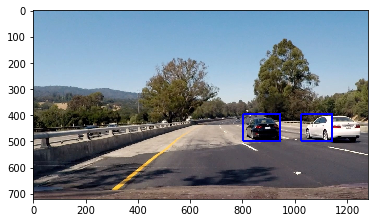

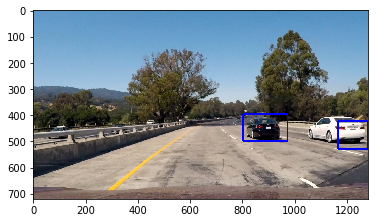

In [29]:
frames_tracked = frame_tracking() #instantiate a new object of vehicle class and reset object variables
frames_tracked.full_search_counter = -1000 #3
images = glob.glob('test_images/test*.jpg')
for _ in range(1):
    for fname in images:
        frames_tracked = frame_tracking() #instantiate a new object of vehicle class and reset object variables
        frames_tracked.full_search_counter = -1000 #only do full search
        frames_tracked.num_frame_track = 1000 #10 for video
        frames_tracked.heat_thresh = 0 #0 #2 for video
        #print(len(frames_tracked.cars_detected))
        image = plt.imread(fname)
        t0 = time.time()
        image = detection_pipeline(image)
        t1 = time.time()
        #print(t1-t0)
        #print(len(frames_tracked.cars_detected))
        #print(frames_tracked.can_do_fast_search)
        plt.imshow(image)
        plt.show()
        #output_fname = 'output_images/out_'+fname[12:]
        #print(output_fname)
        #plt.imsave(output_fname,image, format='jpg')

In [ ]:
print(frames_tracked.cars_detected[0].best_centroid)
print(frames_tracked.can_do_fast_search)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
frames_tracked = frame_tracking() #instantiate a new object of vehicle class and reset object variables
#frames_tracked.full_search_counter = -10000 #9
frames_tracked.num_frame_track = 10 #1000 #10 for video
frames_tracked.heat_thresh = 2 #0 #5 for video
prj_output = 'test_images/output_mini_test_vid_0211.mp4'
vid = VideoFileClip('test_images/mini_test_vid.mp4')
output_clip = vid.fl_image(detection_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(prj_output, audio=False)

In [ ]:
print(frames_tracked.num_use_fast_search)
print(frames_tracked.num_use_full_search)

In [ ]:
frames_tracked = frame_tracking() #instantiate a new object of vehicle class and reset object variables
#frames_tracked.full_search_counter = -10000 #9
frames_tracked.num_frame_track = 10 #1000 #10 for video
frames_tracked.heat_thresh = 2 #0 #5 for video
prj_output = 'output_project_video_0212B.mp4'
vid = VideoFileClip('project_video.mp4')
output_clip = vid.fl_image(detection_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(prj_output, audio=False)

In [ ]:
#To test out different settings for running average
run_avg_list = [0.5,0.6,0.7,0.8]
file_name_list = ['output_project_video_05.mp4', 'output_project_video_06.mp4', 'output_project_video_07.mp4', 'output_project_video_08.mp4']
for ii in range(len(run_avg_list)):
    frames_tracked = frame_tracking() #instantiate a new object of vehicle class and reset object variables
    frames_tracked.avg_factor = run_avg_list[ii]
    prj_output = file_name_list[ii]
    vid = VideoFileClip('project_video.mp4')
    output_clip = vid.fl_image(detection_pipeline) #NOTE: this function expects color images!!
    %time output_clip.write_videofile(prj_output, audio=False)

In [ ]:
vid_frames = []
vid = VideoFileClip('project_video.mp4')
for img in vid.iter_frames():
    vid_frames.append(img)

In [ ]:
img_test = vid_frames[int(6*25)]
plt.imshow(img_test)
plt.show()

plt.imsave('test_images/hard_pos4.jpg', img_test, format='jpg')

In [ ]:
#Create a test video of much smaller size
from moviepy.editor import ImageSequenceClip
#clip  = VideoFileClip("original_file.mp4")
new_frames = []
for idx in range(int(22*25),int(32*25),1):
    new_frames.append(vid_frames[idx])
new_clip = ImageSequenceClip(new_frames, fps=vid.fps)
new_clip.write_videofile("test_images/mini_test_vid.mp4") 

In [ ]:
#Debug code
#cv2 can read png and jpg fine
#plt reads jpg fine. But for png, it is between 0 and 1

image = plt.imread('../bbox-example-image.jpg')
image = plt.imread('training_data/vehicles/GTI_Far/image0001.png')
image = np.array(image*255,dtype=np.uint8)
print(np.max(image))
plt.imshow(image)
plt.show()

image = cv2.imread('../bbox-example-image.jpg')
print(np.max(image))
image = cv2.imread('training_data/vehicles/GTI_Far/image0001.png')
print(np.max(image))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
# cv2.imshow('General',image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()